In [1]:
import ipydex, sys, time, os
print(sys.executable, time.ctime())
%load_ext ipydex.displaytools

/home/ck/miniconda3/bin/python Sat May 17 21:11:05 2025


In [2]:
import os
import importlib as il

import pandas as pd
import numpy as np
import importlib as il
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
from PIL import Image

import torch
from torch.utils.data import Dataset, random_split, DataLoader
from torch.utils.data.sampler import Sampler
import torch.optim as optim
from torchvision import transforms, models

import classification_methods as clm

%matplotlib inline


In [3]:
# pip install grad-cam
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image

In [4]:
from approach2 import model_evaluation as me

Total groups read: 15


In [17]:
il.reload(clm)
il.reload(me)

m = me.Manager()


Total groups read: 15


In [18]:
me.PARENT_DIR

'/home/ck/Nextcloud/IEE-GE/XAI-DIA/ChocolateClassification'

In [19]:
m.load_model(f"{me.PARENT_DIR}/classification_models/CNN_3.pth")
# m.plot_training_curves()

ChocolateCNN
ChocolateCNN
Loaded model type: ChocolateCNN, epoch: 20, validation accuracy: 97.37076648841355%


In [20]:
m.make_predictions(limit=5, display=False)

5it [00:00, 96.47it/s]


In [9]:
m.model

ChocolateCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=9600, out_features=512, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=512, out_features=9, bias=True)
)

In [53]:
def get_label_str(img_tensor) -> str:
    with torch.no_grad():
        image_outputs = m.model(img_tensor)
        predicted_probs = torch.sigmoid(image_outputs)  # Apply sigmoid for multi-label classification
        predicted_num_labels = (predicted_probs > 0.5).int()  # Convert probabilities to binary predictions

    predicted_num_labels = [int(elt) for elt in predicted_num_labels.cpu().numpy().flatten()]

    res = []
    # print(predicted_probs)
    # print(predicted_num_labels)
    for ln, num_label, prob in zip(
        me.label_names, predicted_num_labels, predicted_probs.cpu().numpy().flatten()
    ):
        if num_label:
            res.append(f"{ln} ({prob})")

    res_str = "; ".join(res)
    return res_str

In [54]:
img_fpath = "" # m.img_fpaths_for_prediction[4]
plt.rcParams['figure.subplot.top'] = .8

def grad_cam_cell(img_fpath):
    # usually the last convolutional layer
    cam = GradCAM(model=m.model, target_layers=[m.model.conv2])
    # Prepare the target
    # targets = [ClassifierOutputTarget(class_idx)]
    # q = m.load_and_preprocess_image(img_fpath)

    img_tensor = m.load_and_preprocess_image(img_fpath)
    label_str = get_label_str(img_tensor)

    grayscale_cam = cam(input_tensor=img_tensor, targets=None)

    cmap_cam = plt.cm.viridis(grayscale_cam)[0, :, : , :3]

    image_np = m.np_img_from_tensor(img_tensor)

    # note  cv2.resize takes x dimension (col index) first
    # image1 = me.cv2.resize(image, (25, 100)) ##:i

    # Overlay the heatmap on the original image
    # cam_image = show_cam_on_image(image_np, grayscale_cam[0], use_rgb=True)

    full_image = np.concatenate((image_np, cmap_cam), axis=1)
    res_fpath = img_fpath.replace("predict_inputs", "gradcam_results2")
    dirpath, _ = os.path.split(res_fpath)
    os.makedirs(dirpath, exist_ok=True)
    plt.figure()
    plt.title(label_str)
    plt.imshow(full_image)
    plt.savefig(res_fpath, bbox_inches="tight")

100%|██████████| 5/5 [00:02<00:00,  2.06it/s]


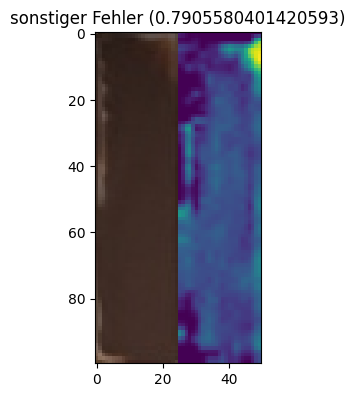

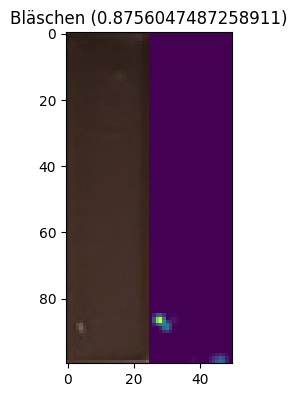

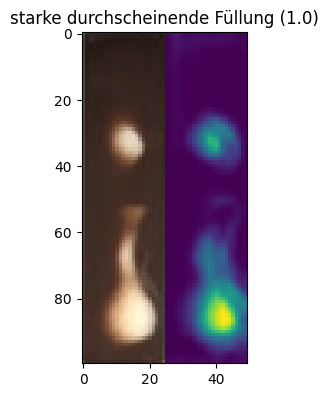

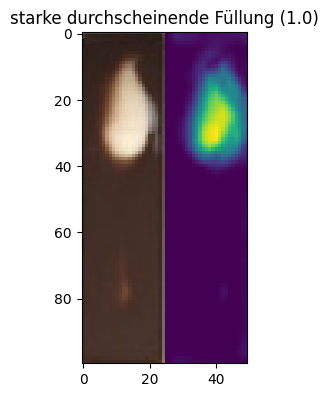

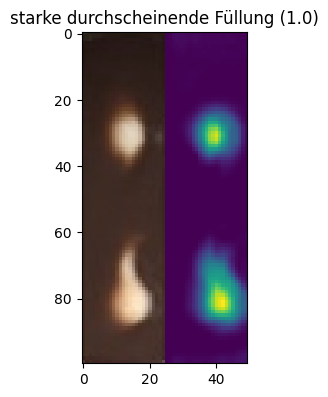

In [55]:
for img_fpath in me.tqdm.tqdm(m.img_fpaths_for_prediction[:30]):
    grad_cam_cell(img_fpath)

In [39]:
cam_image

array([[[ 55,  42, 132],
        [ 54,  42, 132],
        [ 51,  38, 126],
        ...,
        [ 53,  38, 128],
        [ 55,  41, 132],
        [ 79,  65, 156]],

       [[ 57,  44, 134],
        [ 53,  40, 131],
        [ 54,  40, 129],
        ...,
        [ 58,  43, 132],
        [ 54,  40, 131],
        [ 64,  50, 141]],

       [[ 55,  41, 132],
        [ 55,  41, 131],
        [ 51,  38, 127],
        ...,
        [ 54,  39, 128],
        [ 56,  41, 132],
        [ 65,  50, 141]],

       ...,

       [[ 55,  38, 129],
        [ 59, 150, 227],
        [251,  59,  34],
        ...,
        [ 60, 144, 226],
        [249, 199,  34],
        [243,  51,  30]],

       [[ 55,  40, 129],
        [ 54,  39, 194],
        [ 53, 158, 223],
        ...,
        [ 56,  41, 196],
        [ 54, 112, 224],
        [ 55, 161, 225]],

       [[ 63,  48, 136],
        [ 58,  45, 132],
        [ 55,  40, 131],
        ...,
        [ 62,  48, 137],
        [ 64,  52, 140],
        [ 74,  61, 150]]

In [37]:
np.concatenate((image1, cam_image), axis=1).shape

(100, 50, 3)

In [15]:
grayscale_cam[0].shape

(100, 25)

In [16]:
image.shape

(106, 24, 3)

In [61]:
GradCAM??

Init signature: GradCAM(model, target_layers, reshape_transform=None)
Docstring:      <no docstring>
Source:        
class GradCAM(BaseCAM):
    def __init__(self, model, target_layers,
                 reshape_transform=None):
        super(
            GradCAM,
            self).__init__(
            model,
            target_layers,
            reshape_transform)

    def get_cam_weights(self,
                        input_tensor,
                        target_layer,
                        target_category,
                        activations,
                        grads):
        # 2D image
        if len(grads.shape) == 4:
            return np.mean(grads, axis=(2, 3))
        
        # 3D image
        elif len(grads.shape) == 5:
            return np.mean(grads, axis=(2, 3, 4))
        
        else:
            raise ValueError("Invalid grads shape." 
                             "Shape of grads should be 4 (2D image) or 5 (3D image).")
File:           /media/sd-card-disk/m